In [256]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_context("talk")

from functools import partial
import re
import unicodedata
from nlp_utils import CONTRACTION_MAP, LANGUAGE_CODES

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# A. *Business Understanding*

*Gallup*, a global analytics and advice firm, plans to conduct a large-scale survey regarding the trends in public sentiment towards the political parties in the United States. In order to achieve this, they require a model that can rate the sentiment of a Tweet based on its content. Once training of the model has been completed, it is to be deployed as a sentiment analysis tool for that recieves data from the Twitter API.


# B. *Data Understanding*

## B.1 - Overview of the *Sentiment140* Dataset

> *The [Sentiment140](http://help.sentiment140.com/home) dataset will be used to train the classification model. It is a collection of $1,600,000$ tweets, all of which are labelled with a corresponding value indicating sentiment.*

> __The dataset consists of 5 input features and 1 target variable:__
> * __id__ *[int] - unique identifier of the tweet*
> * __date__ *[str] - date the tweet was posted*
> * __user__ *[str] - user that posted the tweet*
> * __text__ *[str] - content of the tweet*
---
> * __target__ *[str] - label indicating sentiment expressed in the tweet* 
>   - *0 = negative*
>   - *4 = positive*

It should be noted that the data in *Sentiment140* is weakly labeled, that is, its labels were generated automatically based on some heuristic. In the technical paper associated with *Sentiment140*, *[Twitter Sentiment Classification using Distant Supervision](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*, this process is summarized: 

> "*With the large range of topics discussed on Twitter, it would be very difficult to manually collect enough data to train a sentiment classifier for tweets. Our solution is to use distant supervision, in which our training data consists of tweets with emoticons. The emoticons serve as noisy labels. For example, __:)__ in a tweet indicate that the tweet contains positive sentiment and __:(__ indicates that the tweet contains negative sentiment.*"

## B.2 - Importing the *Sentiment140* Dataset

In [2]:
corpus = pd.read_csv("data/sentiment140.csv")
corpus.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
corpus.drop(columns=["target", "id", "date", "query", "user"], inplace=True)
corpus.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


## B.3 - Relabeling the *Sentiment140* Dataset

The heuristic outlined in *Section B.1* was used to generate weak labels for *Sentiment140* because it had previsiously been shown that emoticons have the potential of being independent of domain, time, and topic [refer to *[Using Emoticons to Reduce Dependency in Machine Learning Techniques for Sentiment Classification](https://aclanthology.org/P05-2008.pdf)* for more details]. At the time when *Sentiment140* was being compiled, this property made emoticons an ideal heuristic for generating weakly-labeled semantic data. However, utilizing such a simple rule for classifying something as complex as sentiment is bound to produce a substantial number of incorrect labels. Fortunately, there now exists a better alternative to rule-based label generation.

> *__For this analysis, the original labels will be discarded, and new set of labels will be generated by the VADER (Valence Aware Dictionary for sEntiment Reasoning) model.__*

<br>

> *VADER is a sentiment analysis engine that utilizes a parsimonious lexicon in conjunction with a rule-based model. The following features justify its use as a replacement for rule-based label generation:*  
> - *the model relies on a lexicon that is specifically attuned to sentiment in microblog-like contexts (e.g. Twitter)*
> - *the model does not rely on statistical learning to make predictions and therefore does not require training data*
> - *the model is highly accurate -- experimental results show that it predicts the sentiment of tweets with an *F1 Classification Accuracy* of $0.96$ [refer to [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf) for more details]*

In addition to obtaining more accurate labels, performing sentiment analysis with VADER will allow for the additional classification of tweets that express a neutral sentiment. Although tweets such as these were not considered during the construction of *Sentiment104*, the sheer number of tweets combined with the inaccuracy of the current labels makes it likely that a significant number of neutral tweets are present in the dataset. Thus, for the sake of producing a finer classification model, tweets classified as neutral by VADER will remain with that label throughout the remainder of the analysis.

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [5]:
corpus["scores"] = corpus["text"].apply(lambda tweet: sentiment_analyzer.polarity_scores(tweet))
corpus.head()

,text,scores
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","{'neg': 0.129, 'neu': 0.745, 'pos': 0.126, 'co..."
1,is upset that he can't update his Facebook by ...,"{'neg': 0.303, 'neu': 0.697, 'pos': 0.0, 'comp..."
2,@Kenichan I dived many times for the ball. Man...,"{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp..."
3,my whole body feels itchy and like its on fire,"{'neg': 0.321, 'neu': 0.5, 'pos': 0.179, 'comp..."
4,"@nationwideclass no, it's not behaving at all....","{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp..."


In [6]:
corpus["compound score"]  = corpus["scores"].apply(lambda score_dict: score_dict["compound"])
corpus.drop(columns=["scores"], inplace=True)
corpus.head()

,text,compound score
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.0173
1,is upset that he can't update his Facebook by ...,-0.7500
2,@Kenichan I dived many times for the ball. Man...,0.4939
3,my whole body feels itchy and like its on fire,-0.2500
4,"@nationwideclass no, it's not behaving at all....",-0.6597


In [7]:
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return "POSITIVE"
    elif compound_score <= -0.05:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

In [8]:
corpus["label"] = corpus["compound score"].apply(lambda score: get_sentiment_label(score))
corpus.drop(columns=["compound score"], inplace=True)
corpus.head()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEUTRAL
1,is upset that he can't update his Facebook by ...,NEGATIVE
2,@Kenichan I dived many times for the ball. Man...,POSITIVE
3,my whole body feels itchy and like its on fire,NEGATIVE
4,"@nationwideclass no, it's not behaving at all....",NEGATIVE


In [9]:
corpus.to_csv("data/relabeled_sentiment140.csv", index=False)

## B.4 - Viewing a Summary of the *Relabeled Sentiment140* Dataset

In [10]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1600000 non-null  object
 1   label   1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


# C. *Data Processing*

In [185]:
corpus = pd.read_csv("data/relabeled_sentiment140.csv")

## C.1 - Cleaning

In [186]:
def preview(df, col_name, index_start=0, N=5):
    for i in range(index_start, index_start+N):
        print(corpus[col_name][i])
        print("---")

preview_corpus = partial(preview, df=corpus, col_name="text")

### *Replacing Accented Characters*

In [187]:
def remove_accented_characters(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [188]:
corpus["text"] = corpus["text"].apply(remove_accented_characters)

In [189]:
preview_corpus()

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
---


### *Expanding Contractions*

In [190]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    def expand_match(contraction):
        match = contraction.group(0)           
        expanded_match = contraction_mapping[match.lower()] 
        if match[0].isupper():
            expanded_match = expanded_match[0].upper() + expanded_match[1:] 
        return expanded_match
    
    contractions_regex = "(" + '|'.join(sorted(contraction_mapping.keys(), key=lambda x: len(x))) + ")"
    contractions_pattern = re.compile(contractions_regex, flags=re.IGNORECASE|re.DOTALL)
    expanded_text = contractions_pattern.sub(expand_match, text)
    if contractions_pattern.search(expanded_text) is None:
        return expanded_text
    return contractions_pattern.sub(expand_match, expanded_text)

In [191]:
corpus["text"] =  corpus["text"].apply(expand_contractions)

In [192]:
preview_corpus()

@switchfoot http://twitpic.com/2y1zl - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
@nationwideclass no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---


### *Removing Twitter Handles*

In [193]:
def remove_twitter_handles(text):
    twitter_handle_regex = "@\w+"  
    twitter_handle_pattern = re.compile(twitter_handle_regex, flags=re.IGNORECASE|re.DOTALL)
    return twitter_handle_pattern.sub('', text)

In [194]:
corpus["text"] =  corpus["text"].apply(remove_twitter_handles)

In [195]:
preview_corpus()

 http://twitpic.com/2y1zl - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
 I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---


### *Removing Web Addresses*

In [196]:
def remove_web_addresses(text):
    web_address_regex = "(https?\:\/\/\S+)|(w{3}\.\S+\.(com|org|gov|edu)\S*)"
    web_address_pattern = re.compile(web_address_regex, flags=re.IGNORECASE|re.DOTALL)
    return web_address_pattern.sub('', text)

In [197]:
corpus["text"] =  corpus["text"].apply(remove_web_addresses)

In [198]:
preview_corpus()

  - Awww, that is a bummer.  You shoulda got David Carr of Third Day to do it. ;D
---
is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!
---
 I dived many times for the ball. Managed to save 50%  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no, it is not behaving at all. i am mad. why am i here? because I cannot see you all over there. 
---


### *Removing Special Characters*

In [199]:
def remove_special_characters(text):
    special_character_regex = "[^a-zA-z0-9\s]+"  
    return re.sub(special_character_regex, '', text)

In [200]:
corpus["text"] =  corpus["text"].apply(remove_special_characters)

In [201]:
preview_corpus()

   Awww that is a bummer  You shoulda got David Carr of Third Day to do it D
---
is upset that he cannot update his Facebook by texting it and might cry as a result  School today also Blah
---
 I dived many times for the ball Managed to save 50  The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no it is not behaving at all i am mad why am i here because I cannot see you all over there 
---


### *Removing Numbers*

In [202]:
def remove_numbers(text):
    numbers_regex = "[0-9]+"
    return re.sub(numbers_regex, '', text)

In [203]:
corpus["text"] =  corpus["text"].apply(remove_numbers)

In [204]:
preview_corpus()

   Awww that is a bummer  You shoulda got David Carr of Third Day to do it D
---
is upset that he cannot update his Facebook by texting it and might cry as a result  School today also Blah
---
 I dived many times for the ball Managed to save   The rest go out of bounds
---
my whole body feels itchy and like its on fire 
---
 no it is not behaving at all i am mad why am i here because I cannot see you all over there 
---


## C.2 - Tokenization

In [205]:
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

In [206]:
corpus["tokens"] = corpus["text"].map(lambda tweet: tokenizer.tokenize(tweet))
corpus = corpus.loc[:, ["tokens", "label"]]

In [207]:
preview_tokens = partial(preview, df=corpus, col_name="tokens")

In [208]:
preview_tokens()

['awww', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
---
['is', 'upset', 'that', 'he', 'cannot', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']
---
['i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds']
---
['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire']
---
['no', 'it', 'is', 'not', 'behaving', 'at', 'all', 'i', 'am', 'mad', 'why', 'am', 'i', 'here', 'because', 'i', 'cannot', 'see', 'you', 'all', 'over', 'there']
---


## C.3 - Removing Stop Words

In [209]:
STOPWORDS = set(stopwords.words("english"))

In [210]:
def remove_stopwords(tokens, stopwords=STOPWORDS):
    return list(filter(lambda token: token not in stopwords, tokens))

In [211]:
corpus["tokens"] = corpus["tokens"].apply(remove_stopwords)

In [212]:
preview_tokens()

['awww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']
---
['upset', 'cannot', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']
---
['dived', 'many', 'times', 'ball', 'managed', 'save', 'rest', 'go', 'bounds']
---
['whole', 'body', 'feels', 'itchy', 'like', 'fire']
---
['behaving', 'mad', 'cannot', 'see']
---


## C.4 - Lemmatization

### *POS Tagging*

In [213]:
pos_tag = partial(pos_tag, tagset="universal")

In [214]:
corpus["tokens"] =  corpus["tokens"].apply(pos_tag)

In [215]:
preview_tokens()

[('awww', 'ADJ'), ('bummer', 'NOUN'), ('shoulda', 'NOUN'), ('got', 'VERB'), ('david', 'ADJ'), ('carr', 'ADJ'), ('third', 'ADJ'), ('day', 'NOUN')]
---
[('upset', 'ADJ'), ('cannot', 'NOUN'), ('update', 'ADJ'), ('facebook', 'NOUN'), ('texting', 'VERB'), ('might', 'VERB'), ('cry', 'VERB'), ('result', 'NOUN'), ('school', 'NOUN'), ('today', 'NOUN'), ('also', 'ADV'), ('blah', 'VERB')]
---
[('dived', 'VERB'), ('many', 'ADJ'), ('times', 'NOUN'), ('ball', 'VERB'), ('managed', 'VERB'), ('save', 'VERB'), ('rest', 'NOUN'), ('go', 'VERB'), ('bounds', 'NOUN')]
---
[('whole', 'ADJ'), ('body', 'NOUN'), ('feels', 'NOUN'), ('itchy', 'VERB'), ('like', 'ADP'), ('fire', 'NOUN')]
---
[('behaving', 'VERB'), ('mad', 'ADJ'), ('cannot', 'NOUN'), ('see', 'VERB')]
---


### *Lemmatizing*

In [216]:
def get_wordnet_tag(treebank_tag):
    if treebank_tag == 'ADJ':
        return wordnet.ADJ
    elif treebank_tag == 'VERB':
        return wordnet.VERB
    elif treebank_tag == 'NOUN':
        return wordnet.NOUN
    elif treebank_tag == 'ADV':
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [217]:
lemmatizer = WordNetLemmatizer()

def lemmatize(tagged_tokens):
    return [lemmatizer.lemmatize(token[0], get_wordnet_tag(token[1])) for token in tagged_tokens]

In [218]:
corpus["tokens"] =  corpus["tokens"].apply(lemmatize)

In [219]:
preview_tokens()

['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'third', 'day']
---
['upset', 'cannot', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']
---
['dive', 'many', 'time', 'ball', 'manage', 'save', 'rest', 'go', 'bound']
---
['whole', 'body', 'feel', 'itchy', 'like', 'fire']
---
['behave', 'mad', 'cannot', 'see']
---


## C.5 - Removing Empty Token Lists

In [220]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   tokens  1600000 non-null  object
 1   label   1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


In [221]:
corpus = corpus.dropna().reset_index(drop=True)

In [222]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   tokens  1600000 non-null  object
 1   label   1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


## C.6 - Corpus Statistics

### *Label Frequencies*

In [223]:
from nlp_utils import plot_label_frequencies

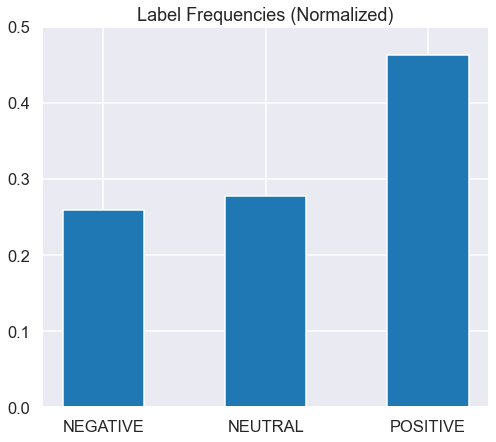

In [224]:
plot_label_frequencies(corpus)

### *Average Length of Tokenized Document (Post-Cleaning)*

In [225]:
from nlp_utils import average_token_length

In [226]:
average_token_length(corpus)

6.92

### *Document Frequencies by Label*

In [227]:
from nlp_utils import get_document_frequencies, plot_document_frequencies

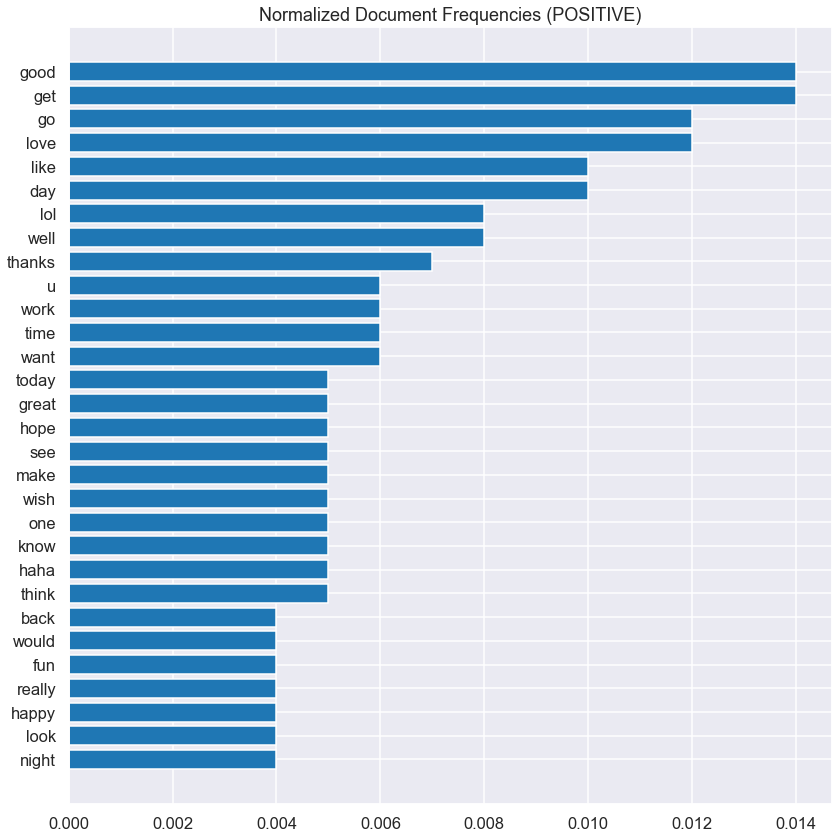

In [228]:
plot_document_frequencies(corpus, "POSITIVE", N=30, figsize=(12,12))

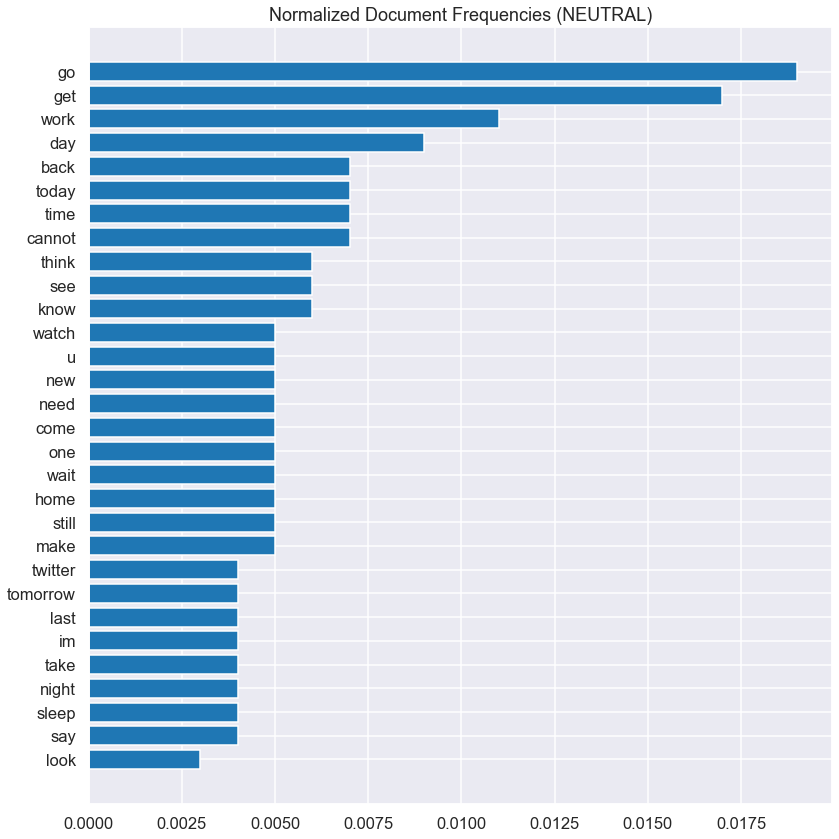

In [229]:
plot_document_frequencies(corpus, "NEUTRAL", N=30, figsize=(12,12))

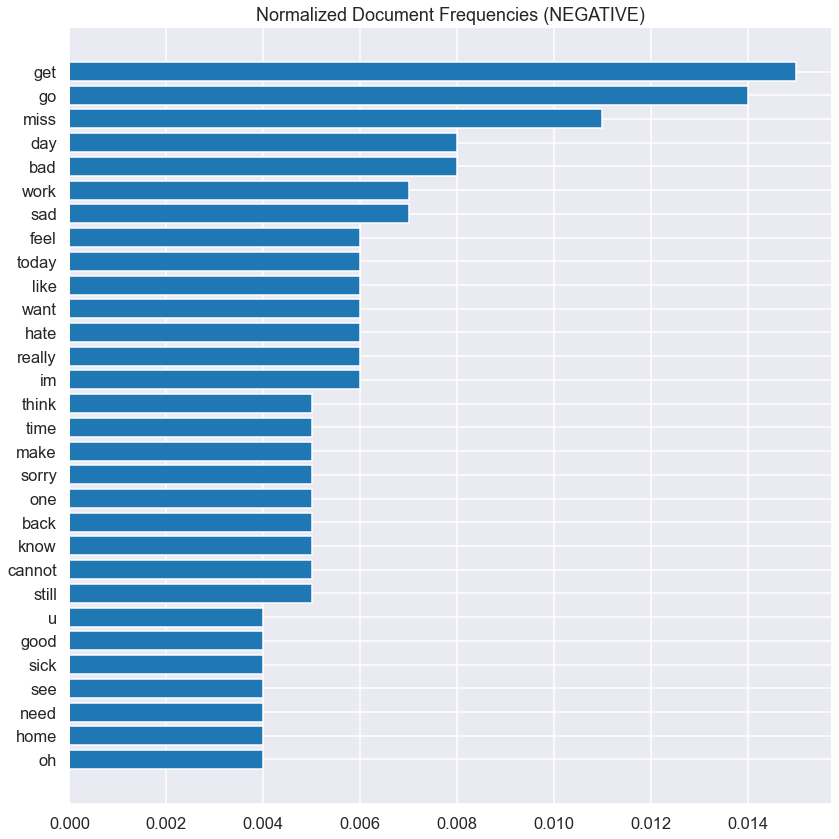

In [230]:
plot_document_frequencies(corpus, "NEGATIVE", N=30, figsize=(12,12))

## C.7 - Identifying Corpus-Specific Stopwords

In [231]:
high_df_words_positive = set(get_document_frequencies(corpus, "POSITIVE", N=20).keys())
high_df_words_neutral = set(get_document_frequencies(corpus, "NEUTRAL", N=20).keys())
high_df_words_negative = set(get_document_frequencies(corpus, "NEGATIVE", N=20).keys())

In [232]:
corpus_stop_words = high_df_words_positive & high_df_words_neutral & high_df_words_negative
corpus_stop_words

{'day', 'get', 'go', 'one', 'time', 'today', 'work'}

## C.8 - Extracting the Training and Validation Sets

In [233]:
corpus.tokens = corpus.tokens.apply(' '.join)

In [234]:
X = corpus["tokens"]
y = corpus["label"]

In [235]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [236]:
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(1280000,) (1280000,)
(320000,) (320000,)


## C.9 - Vectorization

### *Count Vectorization*

In [237]:
cv = CountVectorizer(ngram_range=(1,2), max_features=10_000, stop_words=list(corpus_stop_words))

In [238]:
X_train_CV = cv.fit_transform(X_train)
X_train_CV = pd.DataFrame.sparse.from_spmatrix(X_train_CV)
X_train_CV.columns = sorted(cv.vocabulary_)
X_train_CV.set_index(y_train.index, inplace=True)

In [239]:
X_train_CV.head()

,__,___,aa,aaa,aaah,aaahhh,aaand,aah,aaron,ab,...,zero,zip,zoe,zombie,zomg,zone,zoo,zoom,zune,zzz
1070956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
491543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1350344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1579813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1141196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
X_validate_CV = cv.transform(X_validate)
X_validate_CV  = pd.DataFrame.sparse.from_spmatrix(X_validate_CV)
X_validate_CV.columns = sorted(cv.vocabulary_)
X_validate_CV.set_index(y_validate.index, inplace=True)

In [241]:
X_validate_CV.head()

,__,___,aa,aaa,aaah,aaahhh,aaand,aah,aaron,ab,...,zero,zip,zoe,zombie,zomg,zone,zoo,zoom,zune,zzz
1175673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
828572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
773521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1382764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### *TF-IDF Vectorization*

In [242]:
tv = TfidfVectorizer(ngram_range=(1,2), max_features=10_000, stop_words=list(corpus_stop_words))

In [243]:
X_train_TV = tv.fit_transform(X_train)
X_train_TV = pd.DataFrame.sparse.from_spmatrix(X_train_TV)
X_train_TV.columns = sorted(tv.vocabulary_)
X_train_TV.set_index(y_train.index, inplace=True)

In [244]:
X_train_TV.head()

,__,___,aa,aaa,aaah,aaahhh,aaand,aah,aaron,ab,...,zero,zip,zoe,zombie,zomg,zone,zoo,zoom,zune,zzz
1070956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1350344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1579813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
X_validate_TV = tv.transform(X_validate)
X_validate_TV = pd.DataFrame.sparse.from_spmatrix(X_validate_TV)
X_validate_TV.columns = sorted(tv.vocabulary_)
X_validate_TV.set_index(y_validate.index, inplace=True)

In [246]:
X_validate_TV.head()

,__,___,aa,aaa,aaah,aaahhh,aaand,aah,aaron,ab,...,zero,zip,zoe,zombie,zomg,zone,zoo,zoom,zune,zzz
1175673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
828572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Label Encoding the Target Vectors

In [247]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train.tolist())

LabelEncoder()

In [248]:
y_train = label_encoder.transform(y_train.tolist())
y_validate = label_encoder.transform(y_validate.tolist())

# D. *Modeling*

In [250]:
def plot_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [251]:
mnb = MultinomialNB()

## D.1 - Naive Bayes (Count Vectorized Training Data)

In [252]:
mnb.fit(X_train_CV, y_train)
y_pred_CV = mnb.predict(X_validate_CV)

In [253]:
accuracy_score(y_validate, y_pred_CV)

0.781034375

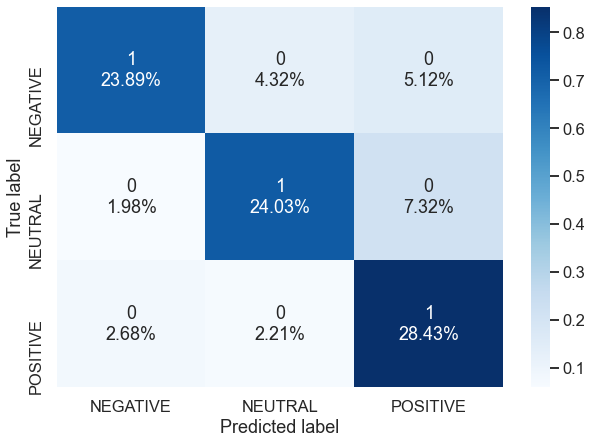

In [260]:
cm = confusion_matrix(y_validate, y_pred_CV, normalize='true')
plot_confusion_matrix(cm, categories=label_encoder.classes_, sum_stats=False, figsize=(10,7))

In [259]:
print(classification_report(y_validate, y_pred_CV, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.72      0.74     82966
     NEUTRAL       0.76      0.72      0.74     88758
    POSITIVE       0.80      0.85      0.82    148276

    accuracy                           0.78    320000
   macro avg       0.78      0.76      0.77    320000
weighted avg       0.78      0.78      0.78    320000



## D.2 - Naive Bayes (TF-IDF Vectorized Training Data)

In [261]:
mnb.fit(X_train_TV, y_train)
y_pred_TV = mnb.predict(X_validate_TV)

In [262]:
accuracy_score(y_validate, y_pred_TV)

0.764184375

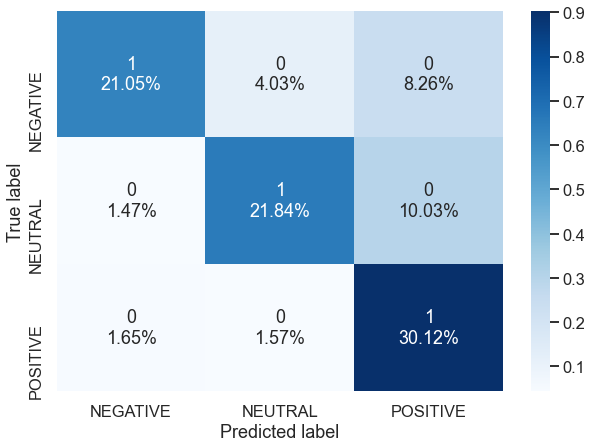

In [269]:
cm = confusion_matrix(y_validate, y_pred_TV, normalize='true')
plot_confusion_matrix(cm, categories=label_encoder.classes_, sum_stats=False, figsize=(10,7))

In [264]:
print(classification_report(y_validate, y_pred_TV, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.63      0.71     82966
     NEUTRAL       0.77      0.66      0.71     88758
    POSITIVE       0.74      0.90      0.81    148276

    accuracy                           0.76    320000
   macro avg       0.78      0.73      0.75    320000
weighted avg       0.77      0.76      0.76    320000



# E. *Limitations & Future Work*

__*Fine-Grained Sentiment Analysis*__
 
Polarity can be categorized with greater precision. In the realm of politics, the degree of polarization is as important as polarity itself. As an example, consider the benefit of being able to use sentiment analysis to discern between hardline Republicans/Democrats versus their more moderate counterparts. Therefore it would be prudent to expand the categories of polarity. For example, a model could be trained to classify sentiment under the following polarities:
- *Very Positive*
- *Positive*
- *Neutral*
- *Negative*
- *Very Negative*

The upside of this approach is that powerful rule-based sentiment analyzers (e.g. VADER) are readily available for use in generating weakly-labeled data with finer grain polarity. 

__*Emotion Detection*__ 

Sentiment can also be categorized with greater precision. A better approach to surveying public sentiment would be to train a model to detect the emotions, rather than the general sentiment, expressed in a tweet. With respect to the political arena, this would provide invaluable information because it would allow trends in sentiment to be broken

The downside of using natural language processing to classify emotions is that the meaning of individual words/phrases becomes more context-specific, and therefore, harder to classify. For example, some words that typically express anger, like "*bad*" or "*kill*", in one context (e.g. "*your product is so bad*" or "*your customer support is killing me*")  might also express happiness in some other context (e.g. "*this is bad ass*" or "*you're killing it*"). 

__*Identification of Domain-Specific Tweets*__

Training a model to classify the sentiment of tweets, without regarding topic, results in the model having to utilize a very large vocabulary. If limited to a particular domain (American politics in this case), it is likely the model will perform better. Therefore, more emphasis needs to be placed on gathering tweets with content related to American politics. Alternatively, a separate model can be trained to specifically identify such tweets. 

__*Utilizing Emoticon Data*__ 

As discussed in *Part B*, the tweets that comprise the *Sentiment104* dataset had their emoticons stripped from them before being incorporated into the dataset. This leads to a signiicant shortcoming in our model, namely, that it does not account for emoticons when determining sentiment. This needs to be addressed because the emoticon feature is very informative when it comes to sentiment, especially with regard to Twitter data. This can easily be achieved by collecting a new set of tweets from the Twitter API, and adjusting text pre-processing such that emoticons are identified and kept as tokens before special characters are removed in general.